# **Analysis for Team Assignment 2**

In [1]:
import sys
from pathlib import Path

# Adjust the path below according to your project's structure
# This should be the path to the directory containing 'notebooks' and 'utils'
project_root = Path.cwd().parent  # If your notebook is directly inside the 'notebooks' directory
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import utils.utility as utility
import imputers.latest_credit_pull_d as lcpd
import imputers.earliest_cr_line_d as ecld
import imputers.last_pymnt_d as lpd
import imputers.numeric_data as nd

# We first import a number of libraries that we will be using in today's class
import pandas as pd
import numpy as np

# Plotting packages we'll use
import matplotlib.pyplot as plt
import seaborn as sns

# Rather than importing the whole sklearn library, we will import only certain modules
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor


## *Importing Data*

In [4]:
path_to_rejected = '../data/LendingClub/rejected_2007_to_2018Q4.csv'
path_to_accepted = '../data/LendingClub/accepted_2007_to_2018Q4.csv'

## *Read rejected and accpeted data into two seperate dataframes*

In [5]:
# Create DFs. 
#df_rejected = pd.read_csv(path_to_rejected)
df_accepted = pd.read_csv(path_to_accepted)


/var/folders/y4/6g9kvk5j1nl_xnqtxdrs3s180000gn/T/ipykernel_61783/590074522.py:3: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accepted = pd.read_csv(path_to_accepted)


In [ ]:
# Check rows and columns
print(df_accepted.shape)
#print(df_rejected.shape)
# 3. output first 5 observations
#df_rejected.head()
df_accepted.head()

## *Examine features* 

In [ ]:
df_accepted.info(verbose=True, show_counts=True)
#df_rejected.info(verbose=True, show_counts=True)


## *Droping columns*

### *Dropping irrelevant columns*

In [6]:
# Get positions of irrelevant columns
rejected_positions_to_drop = [2, 8]
accepted_positions_to_drop = [0, 1, 18, 19, 55, 21, 10, 22]

# Get the column names based on their positions
#rejected_columns_to_drop = df_rejected.columns[rejected_positions_to_drop]
accepted_columns_to_drop = df_accepted.columns[accepted_positions_to_drop]

# Drop irrelevant columns
#df_rejected = df_rejected.drop(rejected_columns_to_drop, axis=1)
df_accepted = df_accepted.drop(accepted_columns_to_drop, axis=1)


### *Dropping columns with a high null count*

In [7]:
# Drop where the null count is greater than or equal to 50% of samples.
df_accepted = utility.drop_null_columns(df_accepted)
#df_rejected = utility.drop_null_columns(df_rejected)

In [ ]:
# Check rows and columns
print(df_accepted.shape)
##print(df_rejected.shape)

In [ ]:
print(list(df_accepted.columns))

## Drop outliers

In [8]:
df_accepted = utility.remove_outliers(df=df_accepted)

### Examine data's distribution

In [ ]:
# Get some summary statistics
#df_rejected.describe()
pd.set_option('display.max_columns', None)  # None means unlimited
df_accepted.describe()

In [9]:
# Get the columns with high skew values as these need to be fixed later
skewed_columns = utility.get_high_skewed_columns(df=df_accepted)
print(skewed_columns)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'fico_range_low', 'fico_range_high', 'open_acc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'last_fico_range_high', 'last_fico_range_low', 'il_util', 'open_rv_24m', 'acc_open_past_24mths', 'mo_sin_old_rev_tl_op', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m']


In [ ]:
# Visualize numerical data for accepted data
utility.visualize_numerical_variables(df_accepted)

In [ ]:
# Visualize numerical data for rejected data
#utility.visualize_numerical_variables(df_rejected)

##  Imputing missing values 

### Imputing dates

In [10]:
# Get a list of all columns that are dates 
potential_date_columns = utility.get_object_columns(df_accepted)

In [11]:
# Display each object with its value count
value_counts = utility.display_value_counts(df_accepted, potential_date_columns)
#value_counts

#### Observations from Value Counts
*Upon looking at the value counts, the following observations were made:*

- There are four dates: 'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'
- These values must be properly dealt with to be used in our analysis
- issue_d: 
    - Can not be imputed. Drop all rows where loan_d is null
- earliest_cr_line:
    - Should be imputed based on


In [12]:
# Drop all rows where issue_d is null
df_accepted = df_accepted.dropna(subset=['issue_d'])

In [13]:
# Type cast all date columns to date objects
date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
df_accepted = utility.to_datetime(df=df_accepted, columns=date_columns)

In [14]:
# Impute missing dates
ecld_imputer = ecld.EarliestCRLineDateImputer()
ecld_imputer.fit(X=df_accepted)
df_accepted = ecld_imputer.transform(X=df_accepted)

lcpd_imputer = lcpd.LatestCreditPullDateImputer()
lcpd_imputer.fit(X=df_accepted)
df_accepted = lcpd_imputer.transform(X=df_accepted)

lpd_imputer = lpd.LastPaymentDateImputer()
lpd_imputer.fit(X=df_accepted)
df_accepted = lpd_imputer.transform(X=df_accepted)

### Categorical Data

In [15]:
# Drop loan_status: Does not meet the credit policy. Status:Fully Paid, Does not meet the credit policy. Status:Charged Off,
# emp_length: 10+ years, < 1 year
df_accepted = df_accepted[(df_accepted.emp_length != '10+ years') &
                          (df_accepted.emp_length != '< 1 year')]

In [16]:
# Make the rest categorical 
category_columns = utility.get_object_columns(df=df_accepted)
result_list = [item for item in category_columns if item not in date_columns]
df_accepted = utility.to_categorical(df=df_accepted, columns=result_list)

In [ ]:
df_accepted.head()

### Imputing categorical data
- Going to start off with SimpleImputer.
- Change later to more complex and specific imputers.

In [ ]:
print(category_columns)

In [17]:
df_accepted.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 799591 entries, 4 to 2260697
Data columns (total 101 columns):
 #    Column                      Non-Null Count   Dtype         
---   ------                      --------------   -----         
 0    loan_amnt                   799591 non-null  float64       
 1    funded_amnt                 799591 non-null  float64       
 2    funded_amnt_inv             799591 non-null  float64       
 3    term                        799591 non-null  category      
 4    int_rate                    799591 non-null  float64       
 5    installment                 799591 non-null  float64       
 6    grade                       799591 non-null  category      
 7    sub_grade                   799591 non-null  category      
 8    emp_length                  716610 non-null  category      
 9    home_ownership              799591 non-null  category      
 10   annual_inc                  799591 non-null  float64       
 11   verification_status         

In [18]:
# Impute categorical data using mode
imputer = SimpleImputer(strategy='most_frequent')
df_accepted[category_columns] = imputer.fit_transform(df_accepted[category_columns])

### Imputing numerical data
*Lets breakdown each numerical column and make a decision on what imputation strategy would be best:*

- `loan_amnt`: drop. Too important not to have and the number of rows without this amount is small.
- `funded_amnt`: 

In [ ]:
print(list(df_accepted.columns))


In [19]:
numerical_columns = utility.get_numerical_columns(df_accepted)
columns_for_grouping_and_median = numerical_columns + ['loan_status']
imputer = nd.NumericDataImputer(group_column='loan_status')
imputer.fit(df_accepted[columns_for_grouping_and_median])
df_accepted[columns_for_grouping_and_median] = imputer.transform(df_accepted[columns_for_grouping_and_median])

In [ ]:
print(numerical_columns)

In [ ]:
df_accepted.info(verbose=True, show_counts=True)

In [ ]:
# There are still some missing values and that's because some groups had no data for certain columns
df_accepted.groupby('loan_status').describe()

In [20]:
# Drop them
df_accepted = df_accepted.dropna()

In [ ]:
df_accepted.info(verbose=True, show_counts=True)

In [21]:
# Save a copy of pre-engineered features
pre_fe_df_accepted = df_accepted.copy(deep=True)

## Feature Engineering

### Feature Engineering Dates Data

In [22]:
# Feature engineer credit history length and loan age
collection_date = pd.to_datetime('2018-12-31')
df_accepted['credit_history_length'] = (df_accepted['issue_d'] - df_accepted['earliest_cr_line']).dt.days / 365.25
df_accepted['loan_age'] = (df_accepted['last_pymnt_d'] - df_accepted['issue_d']).dt.days / 30
df_accepted['months_since_last_credit_pull'] = (collection_date - df_accepted['last_credit_pull_d']).dt.days / 30

/var/folders/y4/6g9kvk5j1nl_xnqtxdrs3s180000gn/T/ipykernel_61783/4126883911.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_accepted['months_since_last_credit_pull'] = (collection_date - df_accepted['last_credit_pull_d']).dt.days / 30


In [23]:
# Drop dates to reduce complexity
df_accepted = df_accepted.drop(date_columns, axis=1)

In [24]:
df_accepted.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 799212 entries, 4 to 2260697
Data columns (total 100 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      799212 non-null  float64
 1   funded_amnt                    799212 non-null  float64
 2   funded_amnt_inv                799212 non-null  float64
 3   term                           799212 non-null  object 
 4   int_rate                       799212 non-null  float64
 5   installment                    799212 non-null  float64
 6   grade                          799212 non-null  object 
 7   sub_grade                      799212 non-null  object 
 8   emp_length                     799212 non-null  object 
 9   home_ownership                 799212 non-null  object 
 10  annual_inc                     799212 non-null  float64
 11  verification_status            799212 non-null  object 
 12  loan_status                    79

## Examine target variable

In [25]:
df_accepted = utility.calculate_roi(df=df_accepted)

/Users/aryonnarice/488-team-assignment-2-1/utils/utility.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['total_received'] = df['total_pymnt'] + df['recoveries'] - df['collection_recovery_fee']
/Users/aryonnarice/488-team-assignment-2-1/utils/utility.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ROI'] = ((df['total_received'] - df['funded_amnt']) / df['funded_amnt'].replace(0, np.nan)) * 100


In [ ]:
sns.histplot(data=df_accepted, x='ROI')
plt.show()

## Encode Categoroical Data
- one-hot encode the following: term, grade, home_ownerhsip, verification_status, loan_status, pymnt_plan, purpose, initial_list_status, application_type, hardship_flag, disbursement_method, and debt_settlement_flag
- encode addr_state: (one host encoding may not suitable since it will increase dimensionality)

In [26]:
# Some how changed to type object needs to be category
category_columns = utility.get_object_columns(df=df_accepted)
df_accepted = utility.to_categorical(df=df_accepted, columns=category_columns)

In [27]:
# One hot encoding on all
one_hot_features = utility.get_category_columns(df=df_accepted)
df_accepted = utility.one_hot_encode(df=df_accepted, columns_to_encode=one_hot_features)

In [28]:
df_accepted.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 799212 entries, 4 to 2260697
Data columns (total 233 columns):
 #    Column                               Non-Null Count   Dtype  
---   ------                               --------------   -----  
 0    loan_amnt                            799212 non-null  float64
 1    funded_amnt                          799212 non-null  float64
 2    funded_amnt_inv                      799212 non-null  float64
 3    int_rate                             799212 non-null  float64
 4    installment                          799212 non-null  float64
 5    annual_inc                           799212 non-null  float64
 6    dti                                  799212 non-null  float64
 7    delinq_2yrs                          799212 non-null  float64
 8    fico_range_low                       799212 non-null  float64
 9    fico_range_high                      799212 non-null  float64
 10   inq_last_6mths                       799212 non-null  float64
 11   op

## Fix Skewed Features

In [29]:
arcsinh_df_accepted = df_accepted.copy(deep=True)

In [30]:
# Get the columns with high skew values
skewed_columns = utility.get_high_skewed_columns(df=arcsinh_df_accepted)
arcsinh_df_accepted = utility.fix_skewed_features(arcsinh_df=arcsinh_df_accepted, skewed_features=skewed_columns)

## Standardize Features

In [31]:
# We can now define the scaler we want to use and apply it to our dataset
scaler = StandardScaler()
numeric_columns = utility.get_numerical_columns(df=arcsinh_df_accepted)
arcsinh_df_accepted = utility.scale_numeric(arcsinh_df_accepted, numeric_columns, scaler)

# Let's check out varible's distribution after the rescaling
#utility.visualize_numerical_variables(df=arcsinh_df_accepted)

In [ ]:
arcsinh_df_accepted.info(verbose=True, show_counts=True)

## Apply Lasso Regression

In [32]:
# Split out dependent variable (y) and independent variables (X)
y = arcsinh_df_accepted['ROI_arcsinh'].values
X = arcsinh_df_accepted.drop(columns=['ROI_arcsinh'])

In [33]:
# Train-Test-Split our Sample
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=42)

In [34]:
# Use Lasso Regression
lasso = Lasso(alpha=0.1) # Starting value, consider tuning this
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [35]:
# Check accuracy
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAE Score: {mae}")

Mean Squared Error: 0.14218868621473973
R^2 Score: 0.8578153886283718
MAE Score: 0.30908364212557493


### Reduce Dimensionality using PCA

In [40]:
pca = PCA(n_components=0.95) # Retain 95% of the variance
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train, y_test = model_selection.train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [41]:
lasso = Lasso(alpha=0.1) # Starting value, consider tuning this
lasso.fit(X_train_pca, y_train)

Lasso(alpha=0.1)

In [42]:
y_pred = lasso.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAE Score: {mae}")

Mean Squared Error: 0.2874094330896692
R^2 Score: 0.7125988034893428
MAE Score: 0.4557877243944553


##### Significant improvment. We will use this as a baseline. Can we do better than ______?

## Evaluate Feature Importance

### Get the importance of each original feature

In [43]:
# pca is our PCA object and lasso is our trained Lasso model
lasso_coefficients = lasso.coef_
pca_components = pca.components_

# Calculate feature importance
feature_importance = np.dot(lasso_coefficients, pca_components)

# feature_importance now holds the importance of each original feature

### Create a DF with each feature and its importance

In [ ]:
feature_names = X.columns
importance_scores = feature_importance

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})

# Sort the DataFrame by importance score
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
pd.set_option('display.max_rows', None)
sorted_feature_importance_df

### Visualize the top 20 features importances

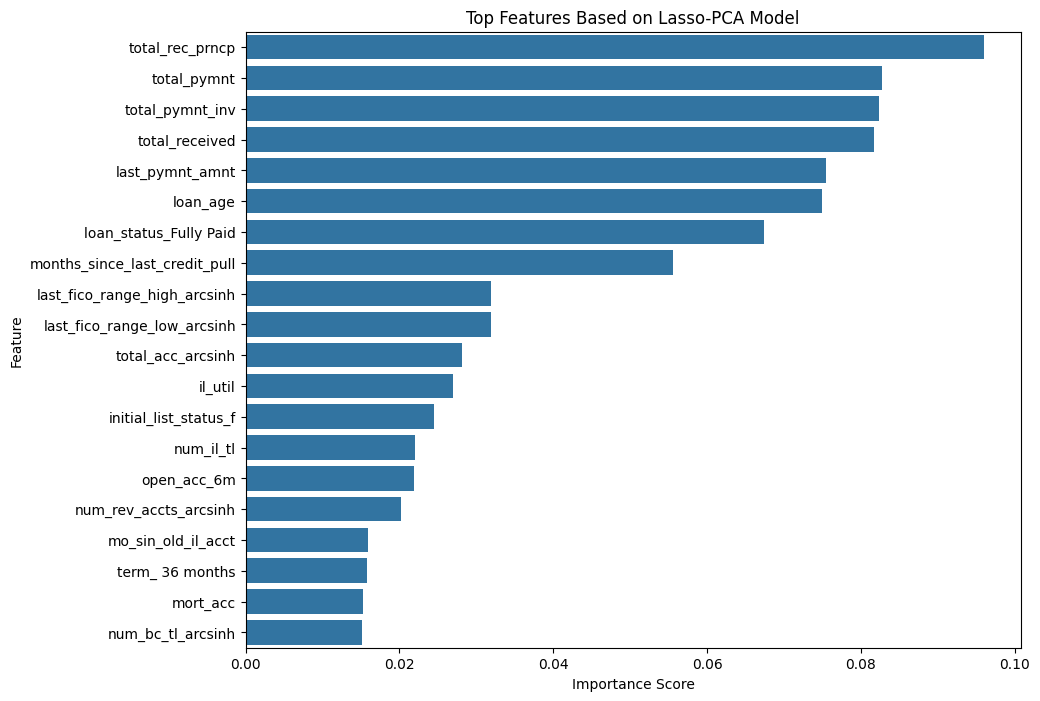

In [45]:
# Use only the top N features for a clearer visualization
top_n = 20
top_features = sorted_feature_importance_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title('Top Features Based on Lasso-PCA Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

## Implement Random Forest

### Random Forest on All Features

#### Create RandomForestRefressor using Raw Data


In [46]:
# Train-Test-Split our Sample
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=42)

In [47]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2,
                                          min_samples_leaf=1, max_features=None, random_state=42, n_jobs=-1)

# Fit 'rfr' to PCA training set
rfr.fit(X_train, y_train)

# Predict the test set labels 'y_pred_rfr'
y_pred_rfr = rfr.predict(X_test)

# Output the accuracy of our prediction
print(f"Accuracy of Random Forest Regressor is {round(accuracy_score(y_test, y_pred_rfr)*100,2)}%")

KeyboardInterrupt: 

#### Assessing Accuracy

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAE Score: {mae}")

#### Finetuning Hyperparameters

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt']
}

# Instantiate the search
random_search = RandomizedSearchCV(estimator=rfr, param_distributions=param_grid,
                                   n_iter=25, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the search model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", random_search.best_params_)

#### Refine Model

#### Cross Validate

In [ ]:
mae_scores = cross_val_score(rfr, X, y, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -mae_scores

print("MAE scores for each fold:", mae_scores)
print("Mean MAE across folds:", mae_scores.mean())

### Random Forest on PCA Data

#### Create RandomForestRefressor using PCA reduced data

In [48]:
rfr1 = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2,
                                          min_samples_leaf=1, max_features=None, random_state=42, n_jobs=-1)

# Fit 'rfr' to PCA training set
rfr1.fit(X_train_pca, y_train)

# Predict the test set labels 'y_pred_rfr'
y_pred_rfr = rfr1.predict(X_test_pca)

# Output the accuracy of our prediction
print(f"Accuracy of Random Forest Regressor on PCA data is {round(accuracy_score(y_test, y_pred_rfr)*100,2)}%")

KeyboardInterrupt: 

#### Assessing Accuracy

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAE Score: {mae}")

#### Fine tuning using Hyper parameters

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt']
}

# Instantiate the search
random_search = RandomizedSearchCV(estimator=rfr1, param_distributions=param_grid,
                                   n_iter=25, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the search model
random_search.fit(X_train_pca, y_train)

# Print the best parameters
print("Best parameters:", random_search.best_params_)

#### Refine Model

#### Cross Validate Model

In [ ]:
mae_scores = cross_val_score(rfr1, X_pca, y, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -mae_scores

print("MAE scores for each fold:", mae_scores)
print("Mean MAE across folds:", mae_scores.mean())


### Random Forest on Smaller Dataset

#### Select the Most Important Features

In [ ]:
# Calculate cumulative importance
sorted_feature_importance_df['Cumulative_Importance'] = sorted_feature_importance_df['Importance'].cumsum()

# Determine the number of features required to reach the cumulative importance threshold
threshold = 0.95  # for example, 95% of the total importance
important_features = sorted_feature_importance_df[sorted_feature_importance_df['Cumulative_Importance'] <= threshold]['Feature'].values
print(f"The numebr of features needed to retain 95% of importance is: {len(important_features)}")

In [ ]:
# Select most important features, include target variable
rfr2_data = arcsinh_df_accepted[important_features + 'ROI_arcsinh']

#### Create a new Dataset using most important features only

In [ ]:
# Set up target and feature variables
y = rfr2_data['ROI_arcsinh'].values
X = rfr2_data.drop(columns=['ROI_arcsinh'])

#### Create a RandomForestRegressor Using Most Important Features

In [ ]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfr2 = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,
                                          min_samples_leaf=1, max_features=None, random_state=42, n_jobs=-1)

# Fit 'rfr2' to the training set
rfr2.fit(X_train, y_train)

# Predict the test set labels 'y_pred_rfr'
y_pred_rfr = rfr2.predict(X_test)

# Output the accuracy of our prediction
print(f"Accuracy of Random Forest Regressor is {round(accuracy_score(y_test, y_pred_rfr)*100,2)}%")

#### Assessing Accuracy

In [ ]:
y_pred = rfr2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAE Score: {mae}")


#### Tuning Hyperparams

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt']
}

# Instantiate the search
random_search = RandomizedSearchCV(estimator=rfr2, param_distributions=param_grid,
                                   n_iter=25, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the search model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", random_search.best_params_)

#### Refine Model

#### Cross Validate

In [ ]:
mae_scores = cross_val_score(rfr2, X, y, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -mae_scores

print("MAE scores for each fold:", mae_scores)
print("Mean MAE across folds:", mae_scores.mean())

## Implement XGBoost